# Component Matching

Here we try out methods for matching components to clusters, bringing all pieces of the pipeline together.

We access two external data sources:

1. A table of component substance compositions
2. An OctoPart data dump

In [1]:
from pathlib import Path
components_path = Path('../source/jupyter/csv/components/components_with_substance_ratios.csv')
octopart_data_path = Path('../data/octopart')

In [2]:
from partmatcher.infrastructure.octopart import *
parts_service = OctopartDumpRepository(octopart_data_path)

Duplicate mpn "MC06XS3517AFKR2" found in Octopart document "../data/octopart/NXP_MC06XS3517AFKR2.json"; ignoring
Duplicate mpn "S912XET256BVALR" found in Octopart document "../data/octopart/NXP_S912XET256BVAL.json"; ignoring
Duplicate mpn "SPC5643AF0MLU2R" found in Octopart document "../data/octopart/NXP_SPC5643AF0MLU2.json"; ignoring
Duplicate mpn "S912XEQ512J3MALR" found in Octopart document "../data/octopart/NXP_S912XEQ512J3MALR.json"; ignoring
Duplicate mpn "SPC5602BF2MLQ4R" found in Octopart document "../data/octopart/NXP_SPC5602BF2MLQ4R.json"; ignoring
Duplicate mpn "SPC5645BF0VLT1R" found in Octopart document "../data/octopart/NXP_SPC5645BF0VLT1R.json"; ignoring
Duplicate mpn "MPX4100AP" found in Octopart document "../data/octopart/NXP_MPX4100AP.json"; ignoring
Duplicate mpn "PCA9554ABS3,118" found in Octopart document "../data/octopart/NXP_PCA9554ABS3,118.json"; ignoring
Duplicate mpn "MPC563MVR66R" found in Octopart document "../data/octopart/NXP_MPC563MVR66R.json"; ignoring
D

Create separate train and test set of components so we can evaluate how well test components can be matched.

In [3]:
# The percentage of components to use for testing.
TEST_PCT = 0.2

In [4]:
from sklearn.cluster import KMeans
import pandas as pd
components_df = pd.read_csv(components_path, index_col = 0)

# Assign two-level index
new_index = pd.MultiIndex.from_tuples(
    [('Meta', cname) for cname in components_df.columns[:10]] + [('Substance', cname) for cname in components_df.columns[10:]]
)
components_df = components_df.T.set_index(new_index).T

components_shuffled = components_df.sample(len(components_df), replace=False, random_state=23)
split_idx = int(TEST_PCT * len(components_shuffled))
components_test = components_shuffled.iloc[:split_idx]
components_train = components_shuffled.iloc[split_idx:]

In [5]:
def create_substance_based_clustering(components_df, n_clusters: int=100):
    components_clustered = components_df['Substance']
    components_clustered = components_clustered.dropna()
    if 'cluster' in components_clustered.columns:
        components_clustered = components_clustered.drop(columns=['cluster'])
    kmeans = KMeans(n_clusters=n_clusters, random_state=2).fit(components_clustered)
    components_clustered.insert(loc = 0, column = 'cluster', value = kmeans.labels_)
    components_clustered.groupby('cluster').size()
    components_clustered.insert(loc=0, column='name', value = components_df['Meta', 'name'])
    components_clustered.insert(loc=1, column='part_no', value = components_df['Meta', 'part_no'])
    components_clustered.sort_values(by='cluster')
    return components_clustered

In [6]:
from partmatcher.infrastructure.csv_data import *
clustering_df = create_substance_based_clustering(components_train)
clustering = read_clustering_from_df(clustering_df)

### Analyse Clustering

In [7]:
clusters_df = pd.DataFrame([{
    'cluster_id': i,
    'cluster_size': len(cluster.members)
    } for i, cluster in enumerate(clustering.clusters)
]).sort_values('cluster_size', ascending=False)

<AxesSubplot:>

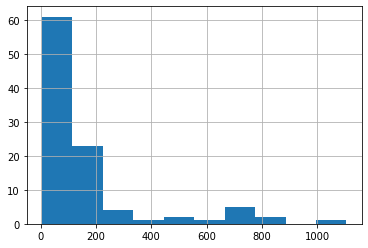

In [8]:
clusters_df['cluster_size'].hist()

In [9]:
clusters_df[:10]

cluster_id  cluster_size
48          48          1106
24          24           856
26          26           845
1            1           756
2            2           737
4            4           717
36          36           713
85          85           670
88          88           648
3            3           501

### Match octopart docs

In [10]:
from partmatcher.domain.similarity import OctopartMatcher
octopart_matcher = OctopartMatcher.from_octopart_repo(parts_service)

Molex
WAGO
EDAC
Hubbell Wiring Device-Kellems
Phoenix Contact
Festo
Idec
HARTING Elektronik
EDAC
Festo
Sensata / Airpax
Categorical for RoHS
Numerical with Metric Units for Max Operating Temperature
Numerical with Metric Units for Min Operating Temperature
Overriding CAT because of Axial, Through Hole
List of Categories for Mount
Categorical for Radiation Hardening
Categorical for Lifecycle Status
Categorical for Case/Package
Overriding CAT because of Lead Free, Not Applicable
List of Categories for Lead Free
Categorical for Packaging
Numerical for Number of Pins
Numerical with Metric Units for Length
Overriding CAT because of Screw, Solder
List of Categories for Termination
Overriding CAT because of Copper, Silver, Tin
List of Categories for Contact Plating
Categorical for Manufacturer Lifecycle Status
Categorical for ELV
Numerical with Metric Units for Operating Supply Voltage
Numerical with Metric Units for Frequency
Categorical for REACH SVHC
Overriding CAT because of Horizontal, R

In [11]:
import random
all_components = [member.part_no for cluster in clustering.clusters for member in cluster.members]
all_components_sampled = random.sample(all_components, 100)

In [12]:
def match_component_pairs(components, component_count=100):
    components_sampled = random.sample(components, min(component_count, len(components)))
    component_pairs = pd.DataFrame([{'component1': c1, 'component2': c2}
        for i, c1 in enumerate(components_sampled) for c2 in components_sampled[i+1:]
    ])
    component_pairs['score'] = component_pairs.apply(lambda row: octopart_matcher(row['component1'], row['component2']), axis=1)
    return component_pairs

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

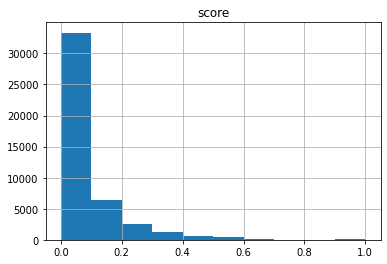

In [13]:
match_component_pairs(all_components, 300).hist()

<AxesSubplot:>

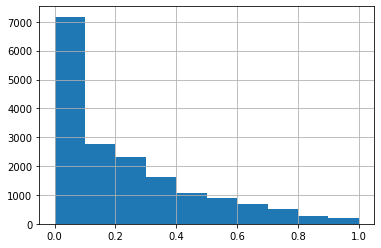

In [14]:
dfs = [
    match_component_pairs([member.part_no for member in clustering.clusters[cluster_id].members], component_count=20)
    for cluster_id in clusters_df['cluster_id']]
within_cluster_df = pd.concat(dfs)
within_cluster_df['score'].hist()

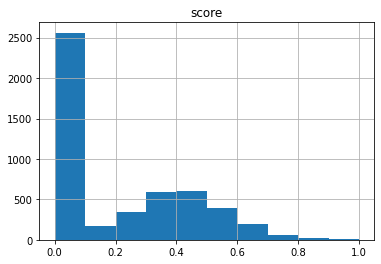

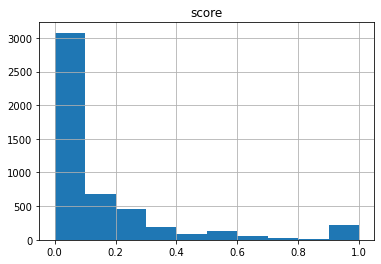

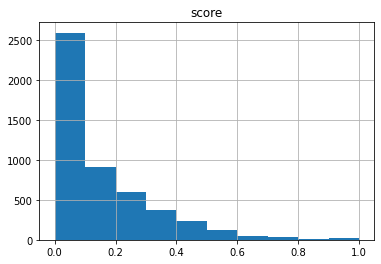

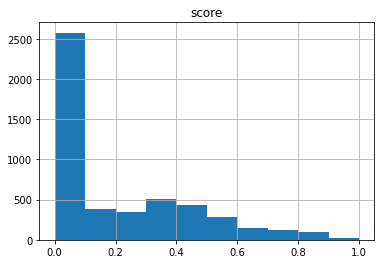

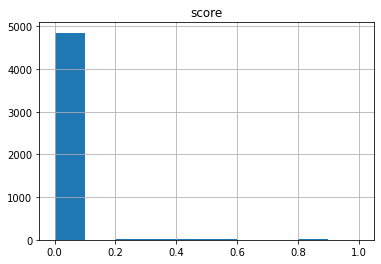

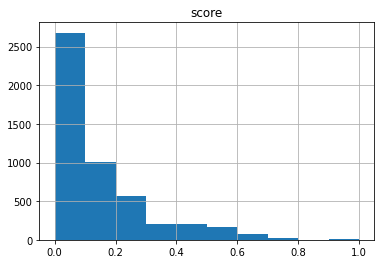

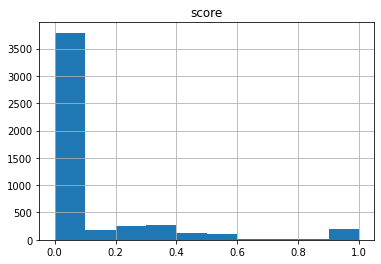

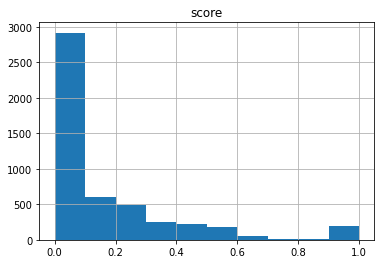

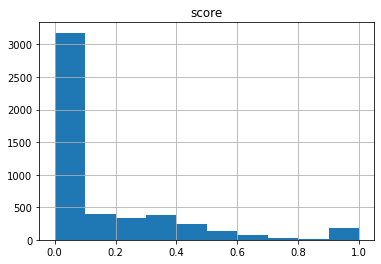

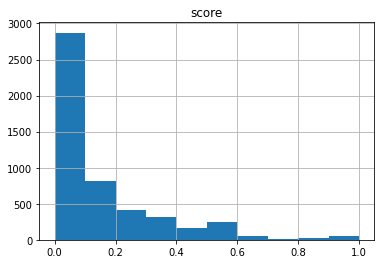

In [15]:
for cluster_id in clusters_df.iloc[:10]['cluster_id']:
    match_component_pairs([member.part_no for member in clustering.clusters[cluster_id].members]).hist()

Which is the closest match for any part?

In [16]:
cluster_by_part = {member.part_no: cluster_id for cluster_id, cluster in enumerate(clustering.clusters) for member in cluster.members}

In [17]:
correct = 0
total = 20
for part_no in random.sample(all_components, total):
    cluster_scores = {
        cluster_id: max(octopart_matcher(part_no, member.part_no) for member in cluster.members if part_no != member.part_no)
        for cluster_id, cluster in enumerate(clustering.clusters)
    }
    max_cluster_id = max(list(cluster_scores.items()), key=lambda t: t[1])[0]
    if cluster_by_part[part_no] == max_cluster_id:
        correct += 1
    print(f'{part_no} real: {cluster_by_part[part_no]} closest: {max_cluster_id}')
print(f'{correct}/{total} ({correct*100.0/total} %)')

S912XEP100BVAGR real: 1 closest: 1
MC9S08QE4CLC real: 85 closest: 48
MPC8313ECVRAGDC real: 45 closest: 45
735278-1 real: 21 closest: 76
MPC8245LVV350D real: 4 closest: 4
MCIMX6S5DVM10AB real: 52 closest: 52
SPC5643LFK0MLQ1 real: 1 closest: 1
6-1437646-2 real: 5 closest: 5
MPC17531ATEJ real: 24 closest: 24
MM908E621ACPEKR2 real: 85 closest: 85
5103310-6 real: 44 closest: 44
MCF51AC256BCFUE real: 48 closest: 48
180916-5 real: 9 closest: 9
MC34PF3000A8EPR2 real: 24 closest: 24
S912ZVH128F2CLQ real: 1 closest: 1
1394759-6 real: 4 closest: 4
MK53DN512ZCLQ10 real: 88 closest: 52
1-1879216-4 real: 2 closest: 0
SPC5604BK0CLL6R real: 26 closest: 26
MC9S08GW32CLH real: 26 closest: 48
15/20 (75.0 %)


## Proper Evaluation

Let’s use our metrics to produce actual mapper metrics.

In [18]:
from partmatcher.domain.mapping import DirectMapper
from partmatcher.domain.similarity import OctopartMatcher
octopart_matcher = OctopartMatcher.from_octopart_repo(parts_service)
direct_mapper = DirectMapper(clustering, octopart_matcher)

Molex
WAGO
EDAC
Hubbell Wiring Device-Kellems
Phoenix Contact
Festo
Idec
HARTING Elektronik
EDAC
Festo
Sensata / Airpax
Categorical for RoHS
Numerical with Metric Units for Max Operating Temperature
Numerical with Metric Units for Min Operating Temperature
Overriding CAT because of Axial, Through Hole
List of Categories for Mount
Categorical for Radiation Hardening
Categorical for Lifecycle Status
Categorical for Case/Package
Overriding CAT because of Lead Free, Not Applicable
List of Categories for Lead Free
Categorical for Packaging
Numerical for Number of Pins
Numerical with Metric Units for Length
Overriding CAT because of Screw, Solder
List of Categories for Termination
Overriding CAT because of Copper, Silver, Tin
List of Categories for Contact Plating
Categorical for Manufacturer Lifecycle Status
Categorical for ELV
Numerical with Metric Units for Operating Supply Voltage
Numerical with Metric Units for Frequency
Categorical for REACH SVHC
Overriding CAT because of Horizontal, R

In [19]:
test_part_no = 'DSP56F807VF80E'
matched = direct_mapper(test_part_no)

In [20]:
def load_components_from_df(components_df: pd.DataFrame) -> domain.ComponentClustering:
    components = []
    for _, row in components_df.iterrows():
        component = domain.MappedComponent(
            part_no=row['Meta', 'part_no'],
            composition=row['Substance'].to_numpy(),
            mass=1.0
        )
        components.append(component)
    return components

In [21]:
# from partmatcher.infrastructure.csv_data import load_components_from_df
test_components = load_components_from_df(components_test)

In [22]:
from typing import List
from tqdm import tqdm
from partmatcher.domain.mapping.evaluation import Metric

class EvaluationContext:
    def __init__(self, test_data: List[domain.MappedComponent], metrics: List[Metric]):
        self.test_data = test_data
        self.metrics = metrics

    def evaluate_mapper(self, mapper) -> pd.DataFrame:
        """Returns a data frame of evaluation results for each test component."""
        return pd.DataFrame([
            {metric.__name__: metric(mapped_component, test_component)
             for metric in self.metrics}
            for mapped_component, test_component in tqdm(
                ((mapper(test_component.part_no), test_component) for test_component in self.test_data),
                total=len(self.test_data))
        ], index=[test_component.part_no for test_component in self.test_data])


In [23]:
from partmatcher.domain.mapping.evaluation import absolute_error, correct_mass_percentage
# from partmatcher.domain.mapping.evaluation import EvaluationContext

metrics = [absolute_error, correct_mass_percentage]
fast_evaluator = EvaluationContext(test_components[:20], metrics)

In [24]:
eval_df = fast_evaluator.evaluate_mapper(direct_mapper)
eval_df.describe()

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


absolute_error  correct_mass_percentage
count       20.000000                20.000000
mean         0.508250                 0.745875
std          0.654163                 0.327081
min          0.000000                 0.127446
25%          0.016232                 0.515680
50%          0.158618                 0.920691
75%          0.968640                 0.991884
max          1.745109                 1.000000

In [25]:
eval_df

absolute_error  correct_mass_percentage
MHT1004NR3              0.135806                 0.932097
MCF51QM128VLHR          0.017643                 0.991179
S9S08SG8E2VTG           0.175369                 0.912316
MC40XSF500EKR2          1.745109                 0.127446
7-745129-1              0.020215                 0.989893
3-641210-8              0.156701                 0.921650
MPC8323EZQADDC          0.000000                 1.000000
PCA9674APW,118          0.191402                 0.904299
1-928776-4              0.005563                 0.997219
MC9S08SU16VFK           0.868565                 0.565718
1-1761606-0             1.268867                 0.365567
S912XEP100J5MALR        0.160535                 0.919733
1-368587-1              0.012000                 0.994000
3-1625890-7             1.340208                 0.329896
640497-1                1.660735                 0.169633
MCIMX6L8DVN10AB         0.000000                 1.000000
MPC850SRCVR50BU         0.000000                 1.000000
MC34PF8100EQEPR2        1.682958                 0.158521
62419-1                 0.587481                 0.706260
MC9S08PA16AVLD          0.135848                 0.932076